## ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


## ⏳ Load and Process Data

In [2]:
# Load the dataset
print("Loading Mars dataset...")
data = np.load("/kaggle/input/d/federicodagani/mars-training-set/mars_for_students.npz")
training_set = data["training_set"]

# Extract images (X) and labels (y) from the training set and test set
X_train_val = np.stack(training_set[:, 0])  # Stack images into a valid array
y_train_val = np.stack(training_set[:, 1])  # Labels are segmentation masks
X_test = np.stack(data["test_set"])  # Stack test images into a valid array

print("Dataset loaded!")

print(f"\nShape of X_train_val: {X_train_val.shape}")
print(f"Shape of y_train_val: {y_train_val.shape}")
print(f"Shape of X_test: {X_test.shape}")

Loading Mars dataset...
Dataset loaded!

Shape of X_train_val: (2615, 64, 128)
Shape of y_train_val: (2615, 64, 128)
Shape of X_test: (10022, 64, 128)


## Detect Outliers

In [3]:
import hashlib
from collections import defaultdict
import matplotlib.pyplot as plt

# Function to calculate the hash of an image
def calculate_image_hash(image):
    return hashlib.md5(image.tobytes()).hexdigest()

# Calculate hashes for each image and store their indices
hash_dict = defaultdict(list)
for idx, image in enumerate(y_train_val):
    img_hash = calculate_image_hash(image)
    hash_dict[img_hash].append(idx)

Duplicate images found!


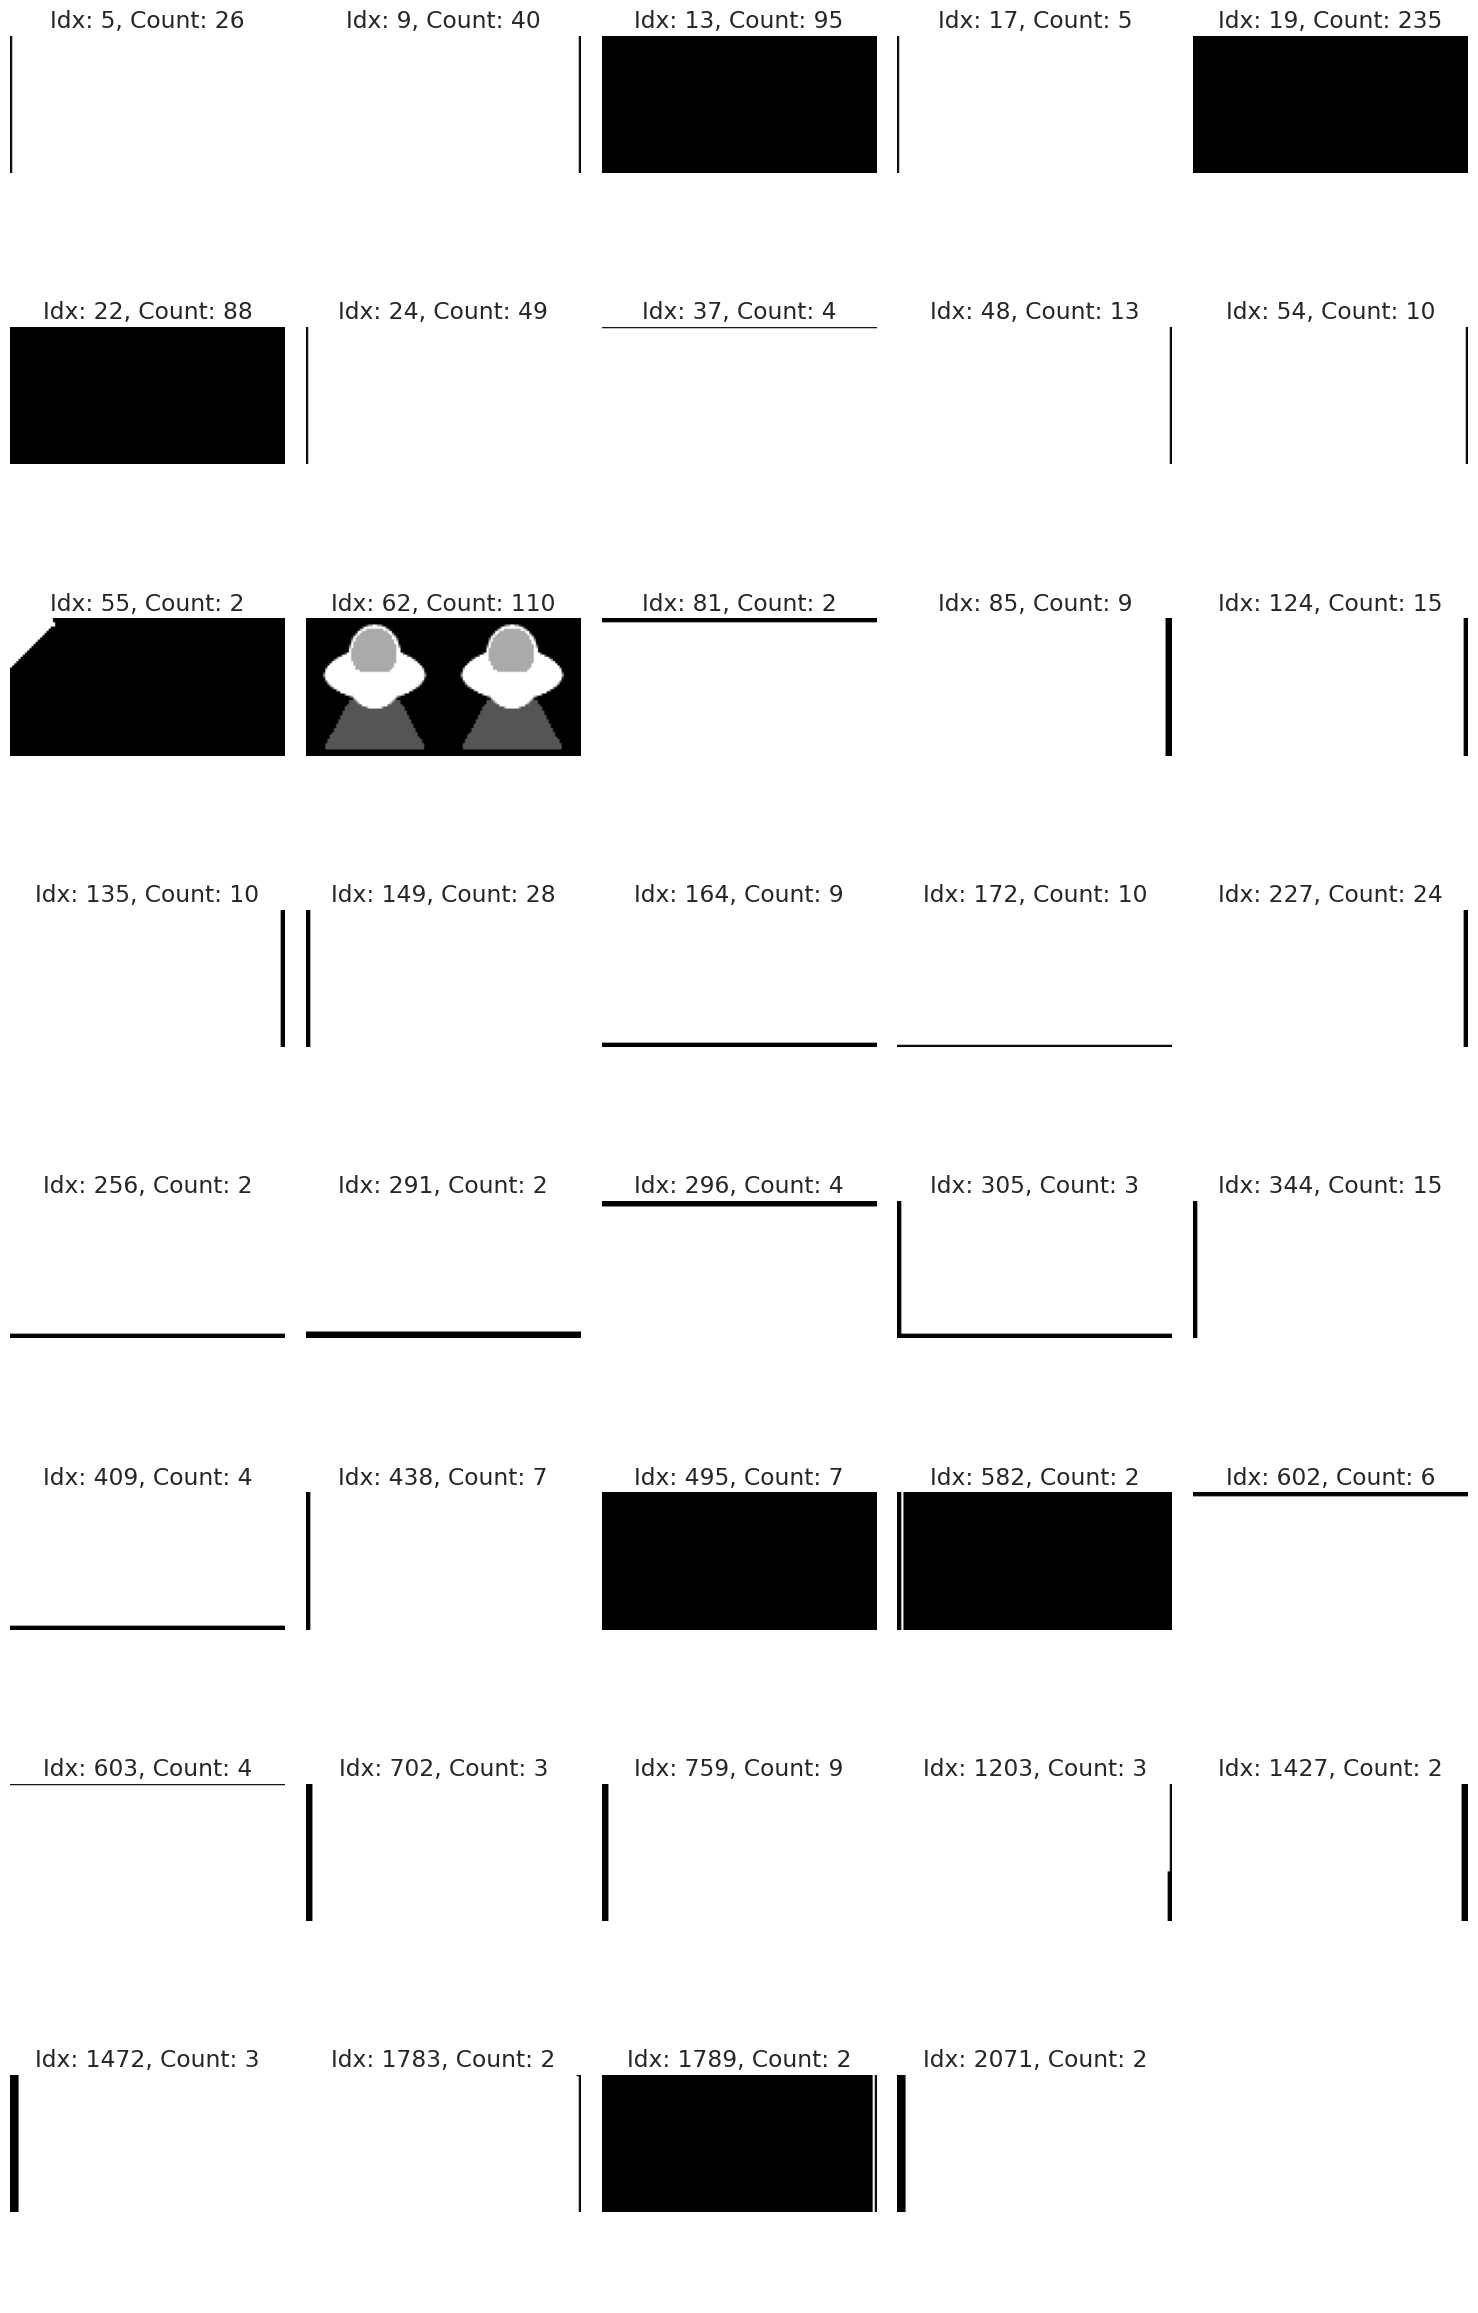

In [4]:
# Find duplicates
duplicates = {key: indices for key, indices in hash_dict.items() if len(indices) > 1}

if duplicates:
    print("Duplicate images found!")
   
    num_duplicates = len(duplicates)
    cols = 5 
    rows = (num_duplicates + cols - 1) // cols  
    
    # Create the figure and subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()  
    
    for i, (img_hash, indices) in enumerate(duplicates.items()):
        # Select one representative image
        representative_idx = indices[0]
        occurrence_count = len(indices)  
        ax = axes[i]
        
        # Plot the image
        if y_train_val[representative_idx].ndim == 3: 
            ax.imshow(y_train_val[representative_idx])
        else: 
            ax.imshow(y_train_val[representative_idx], cmap='gray')
        
        # Set title with hash, occurrences, and first index
        ax.set_title(f"Idx: {representative_idx}, Count: {occurrence_count}")
        ax.axis('off')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

else:
    print("No duplicate images found!")

## Inspect an index

In [5]:
def create_segmentation_colormap(num_classes):
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

In [6]:
def apply_colormap(label, colormap=None):
    
    # Ensure label is 2D
    label = np.squeeze(label)

    # Ensure label values are in the valid range [0, num_classes-1]
    num_classes = len(colormap)  # Get the number of classes from the colormap
    label = np.clip(label, 0, num_classes - 1)  # Clip values to be within range

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

Hash for image at index 2071: 17fec901f6ed4082a70668bf7a334b37


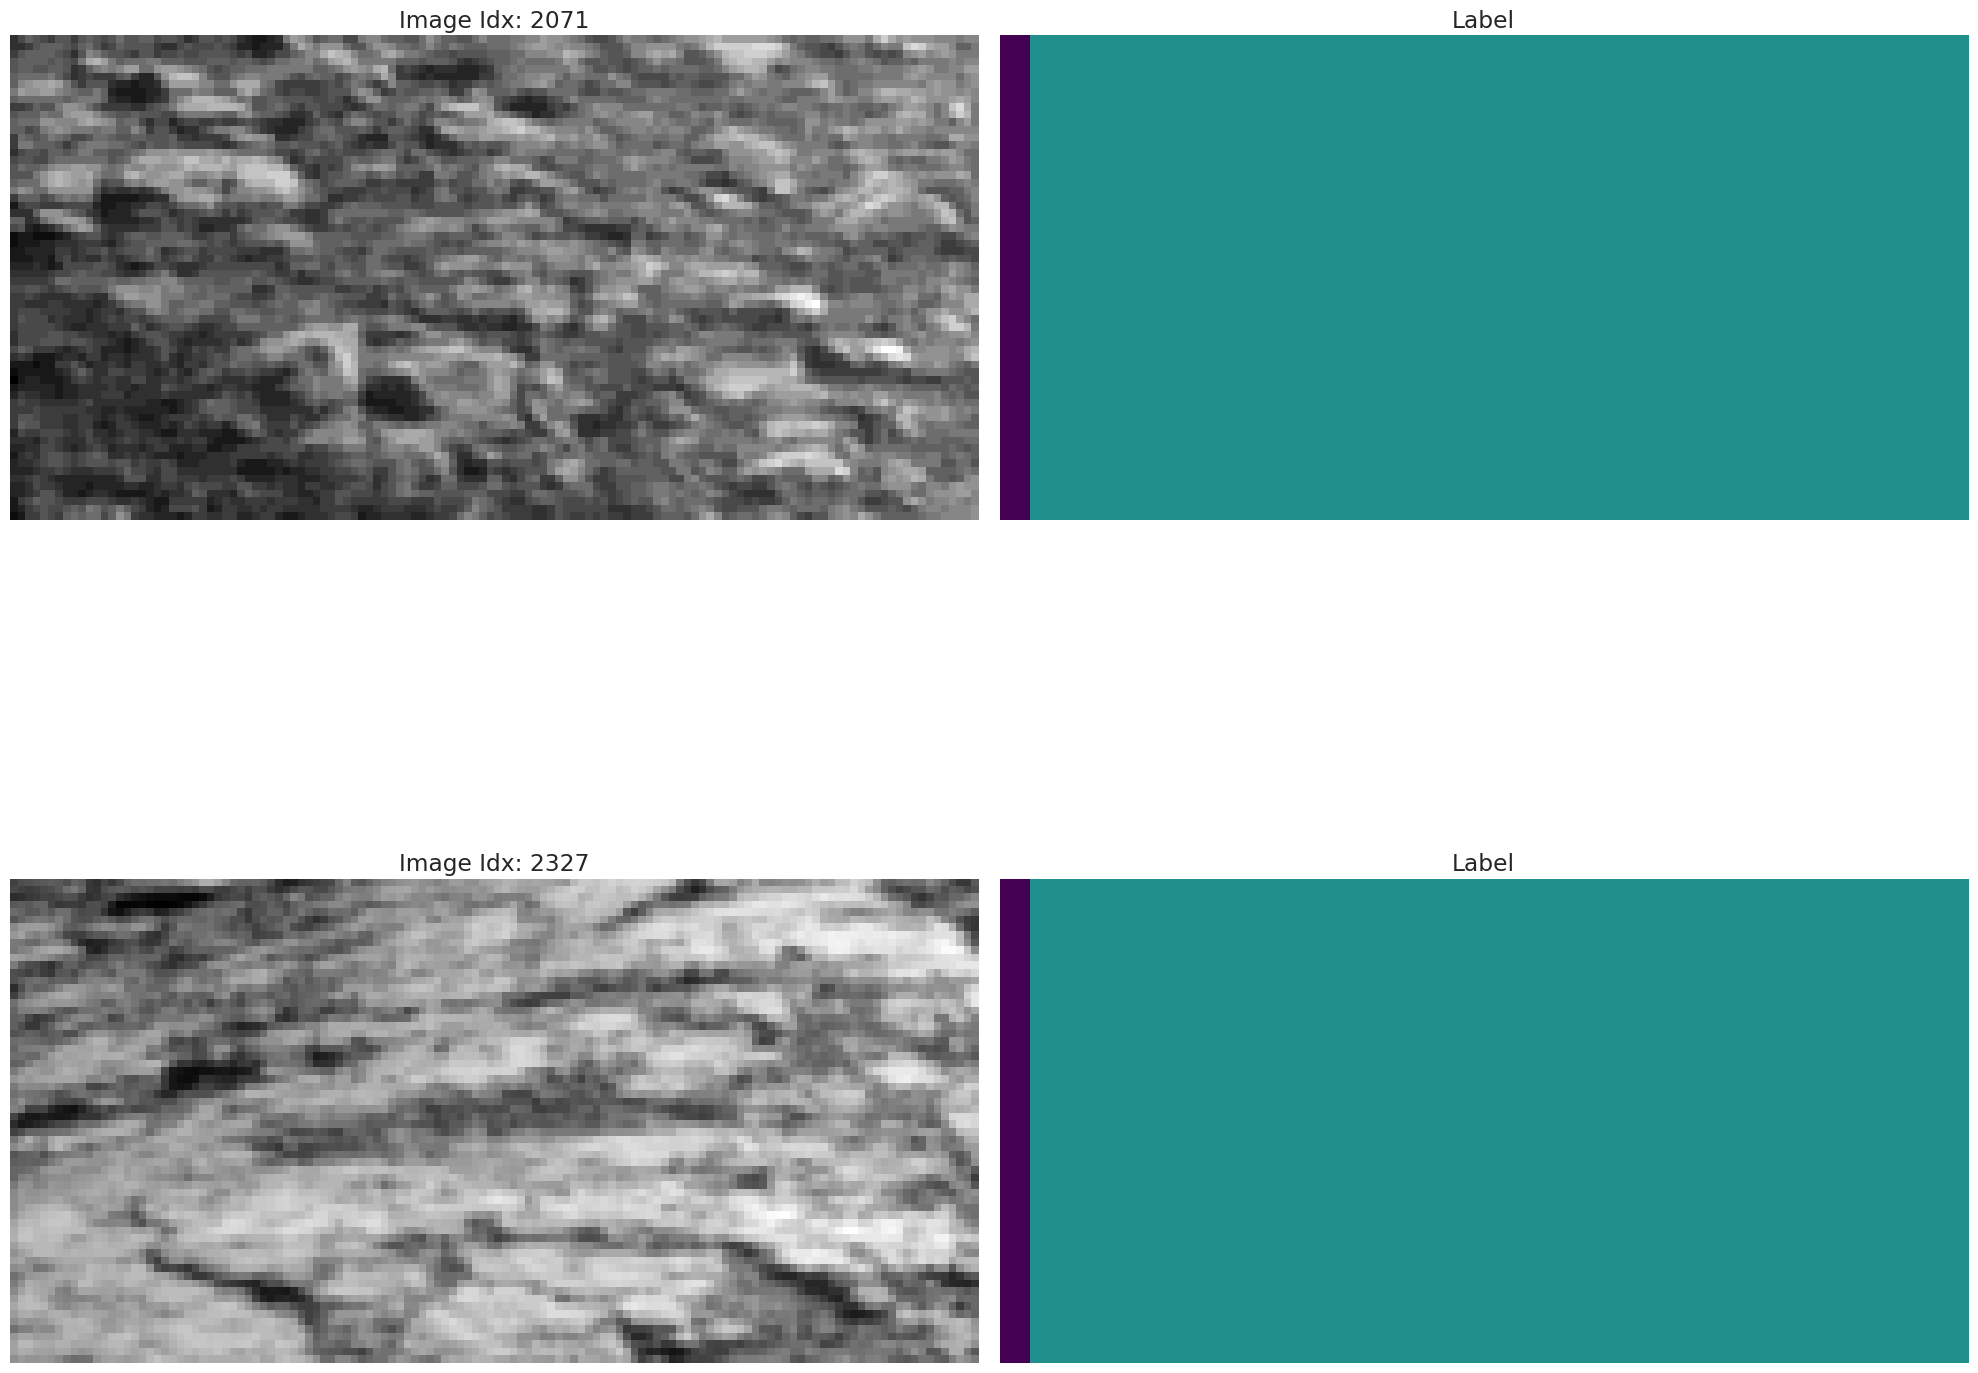

In [7]:
index_of_interest = 2071

# Function to get images associated with a specific index
def get_images_by_index(index):
    img_hash = calculate_image_hash(y_train_val[index])  # Calculate hash
    associated_indices = hash_dict.get(img_hash, [])  # Get duplicate indices
    return img_hash, associated_indices

# Get images and duplicates
img_hash, associated_indices = get_images_by_index(index_of_interest)

if associated_indices:
    print(f"Hash for image at index {index_of_interest}: {img_hash}")
    
    num_images = len(associated_indices)
    cols = 2  # Show image and label side-by-side
    rows = num_images  # One row per image-label pair
    
    # Create colormap for labels
    num_classes = len(np.unique(y_train_val))
    colormap = create_segmentation_colormap(num_classes)

    # Larger figure size for better visuals
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10 * rows))
    axes = axes.reshape(rows, cols)  # Ensure axes is 2D for easy access

    for i, idx in enumerate(associated_indices):
        # Plot the image
        ax_image = axes[i, 0]
        ax_image.imshow(X_train_val[idx], cmap='gray' if X_train_val[idx].ndim == 2 else None)
        ax_image.set_title(f"Image Idx: {idx}")
        ax_image.axis('off')

        # Plot the label
        ax_label = axes[i, 1]
        colored_label = apply_colormap(y_train_val[idx], colormap)
        ax_label.imshow(colored_label)
        ax_label.set_title("Label")
        ax_label.axis('off')

    plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust spacing
    plt.tight_layout()
    plt.show()

else:
    print(f"No duplicates found for image at index {index_of_interest}.")


In [8]:
alien_index = 62

# Get associated indices
img_hash, alin_associated_indices = get_images_by_index(alien_index)

if(X_train_val.shape[0] == 2615):
    X_train_val = np.delete(X_train_val, alin_associated_indices, axis=0)
    y_train_val = np.delete(y_train_val, alin_associated_indices, axis=0)
    print("Outliers removed")
else:
    print("Outliers already removed")

print("Dataset dimension:", X_train_val.shape)

Outliers removed
Dataset dimension: (2505, 64, 128)


## Adjust labels

In [9]:
hash_dict = defaultdict(list)
for idx, image in enumerate(y_train_val):
    img_hash = calculate_image_hash(image)
    hash_dict[img_hash].append(idx)

Duplicate images found!


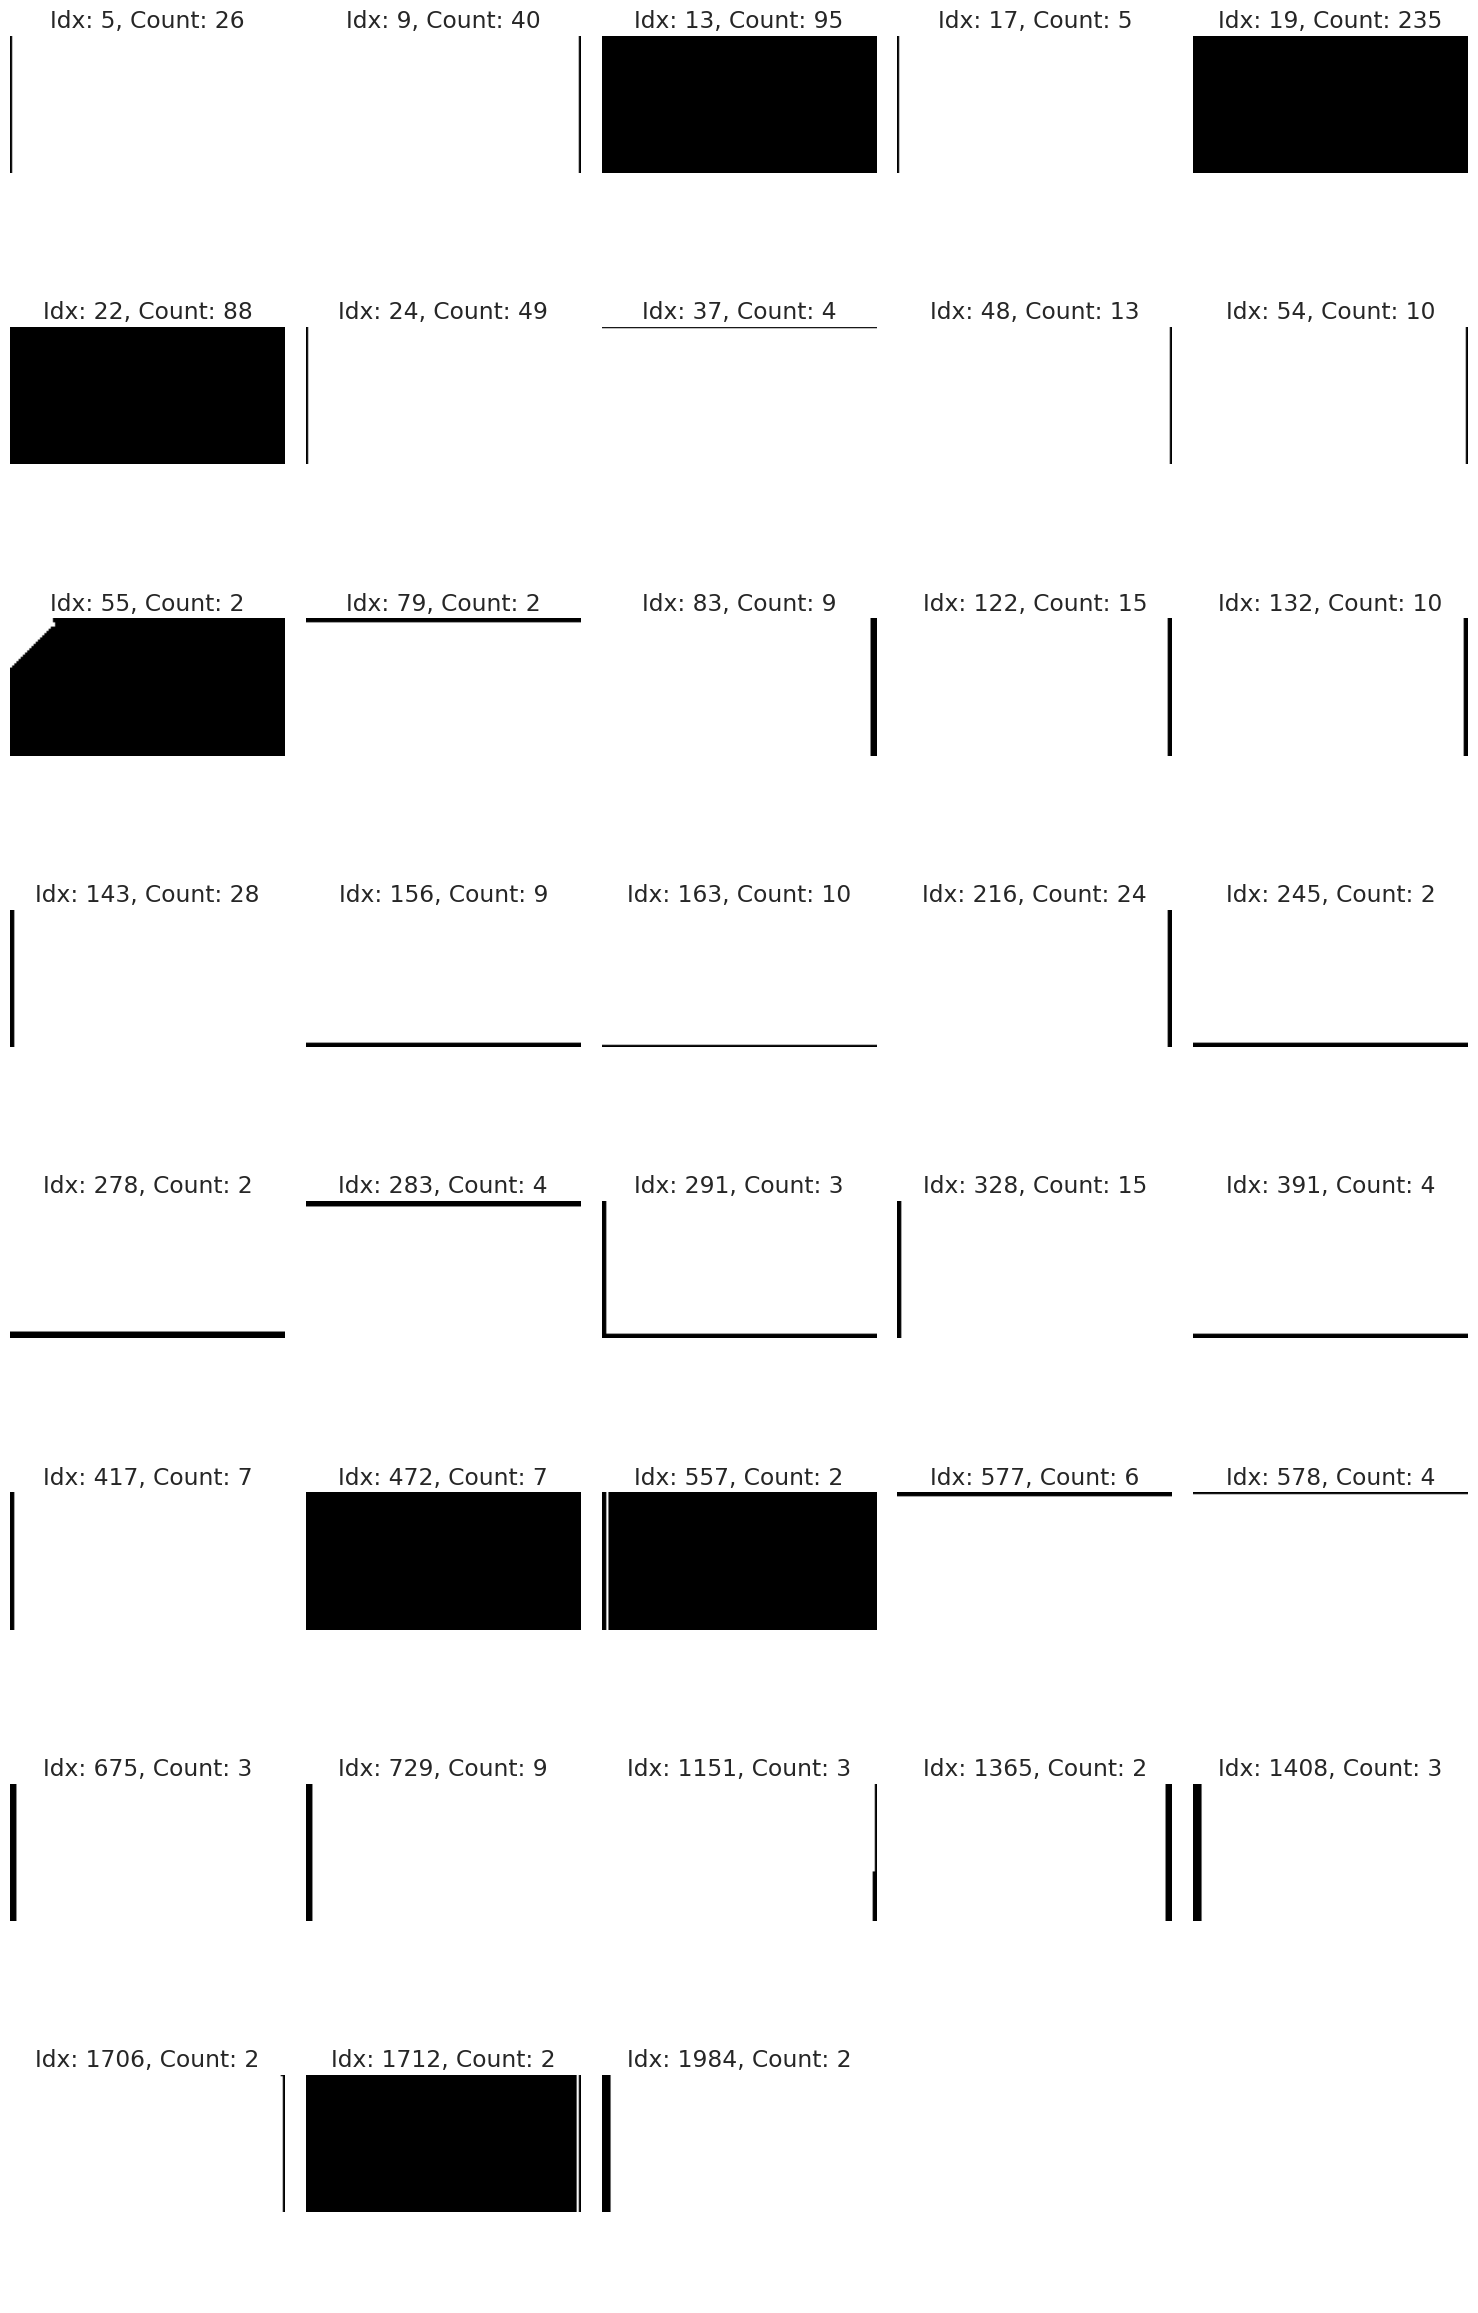

In [10]:
# Find duplicates
duplicates = {key: indices for key, indices in hash_dict.items() if len(indices) > 1}

if duplicates:
    print("Duplicate images found!")
   
    num_duplicates = len(duplicates)
    cols = 5 
    rows = (num_duplicates + cols - 1) // cols  
    
    # Create the figure and subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()  
    
    for i, (img_hash, indices) in enumerate(duplicates.items()):
        # Select one representative image
        representative_idx = indices[0]
        occurrence_count = len(indices)  
        ax = axes[i]
        
        # Plot the image
        if y_train_val[representative_idx].ndim == 3: 
            ax.imshow(y_train_val[representative_idx])
        else: 
            ax.imshow(y_train_val[representative_idx], cmap='gray')
        
        # Set title with hash, occurrences, and first index
        ax.set_title(f"Idx: {representative_idx}, Count: {occurrence_count}")
        ax.axis('off')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

else:
    print("No duplicate images found!")

Hash for image at index 55: fcd6bcb56c1689fcef28b57c22475bad


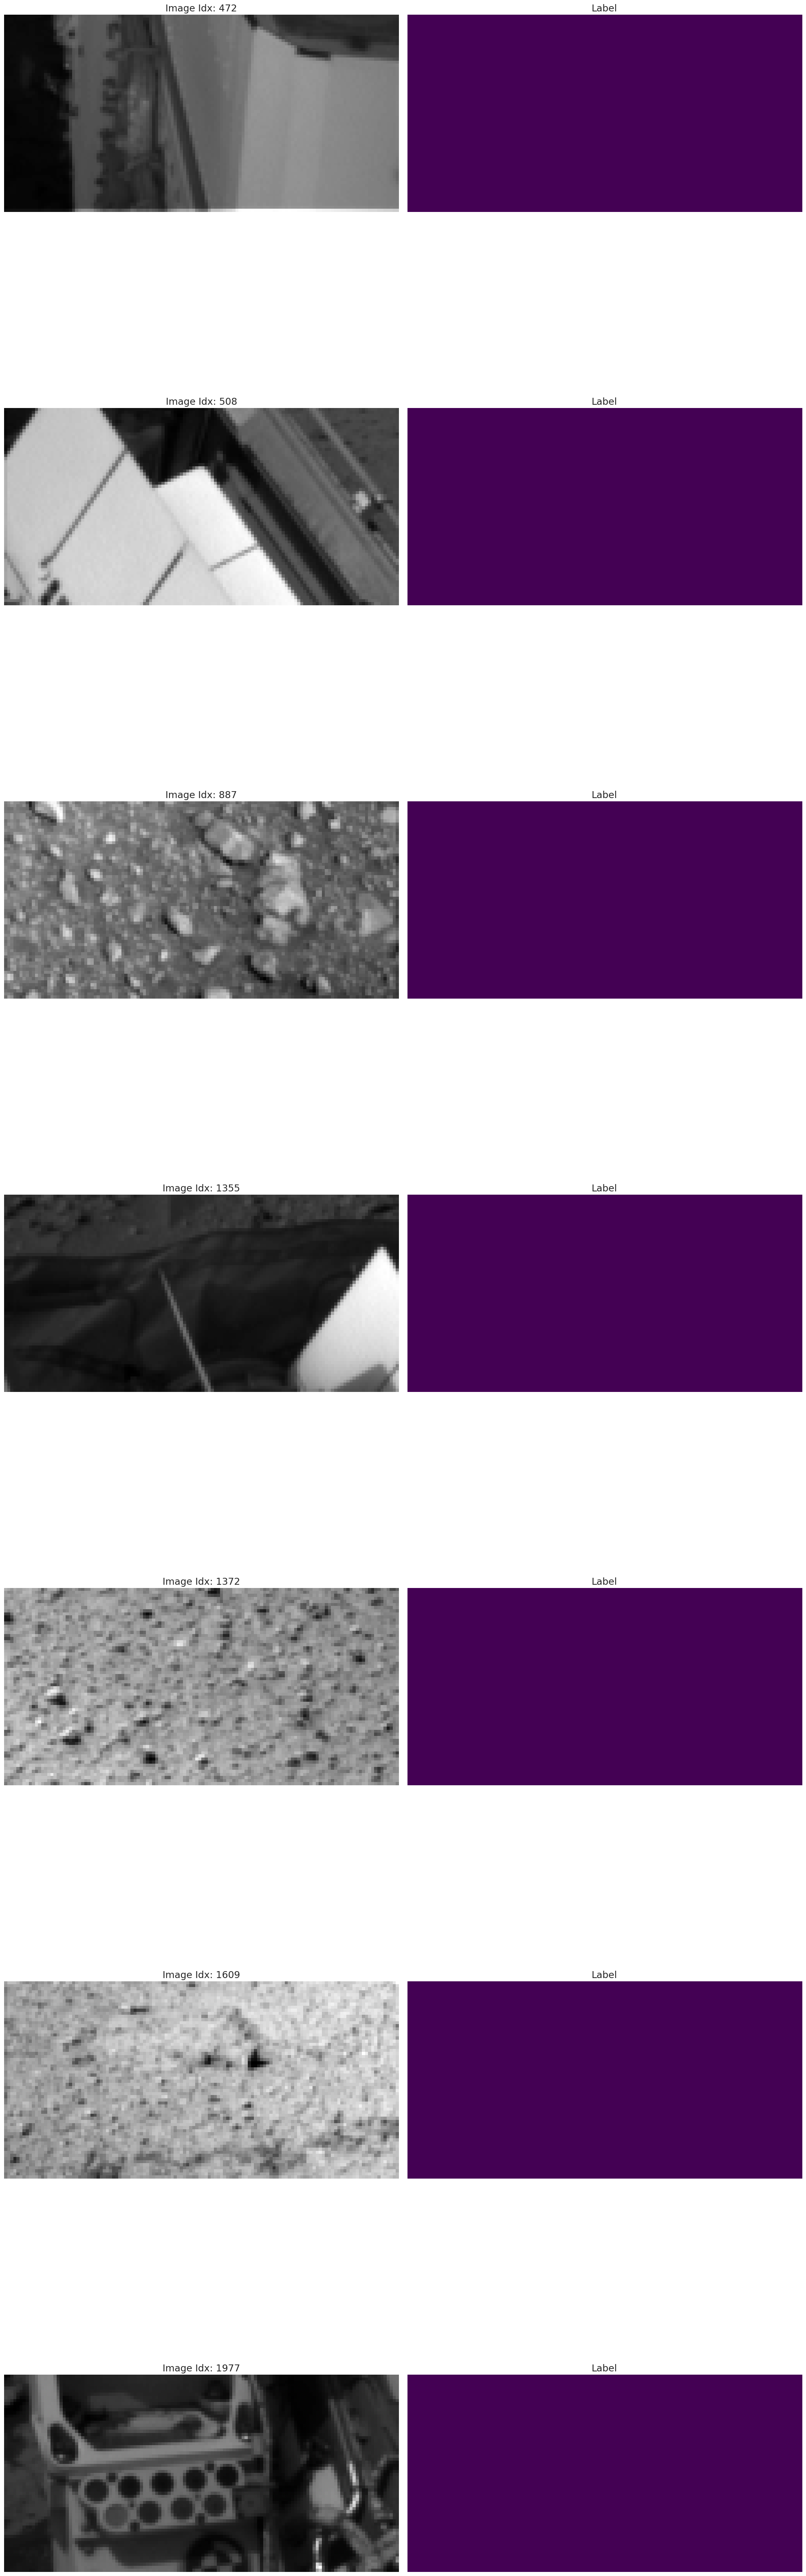

In [28]:
index_of_interest = 55

# Function to get images associated with a specific index
def get_images_by_index(index):
    img_hash = calculate_image_hash(y_train_val[index])  # Calculate hash
    associated_indices = hash_dict.get(img_hash, [])  # Get duplicate indices
    return img_hash, associated_indices

# Get images and duplicates
img_hash, associated_indices = get_images_by_index(index_of_interest)

if associated_indices:
    print(f"Hash for image at index {index_of_interest}: {img_hash}")
    
    num_images = len(associated_indices)
    cols = 2  # Show image and label side-by-side
    rows = num_images  # One row per image-label pair
    
    # Create colormap for labels
    num_classes = len(np.unique(y_train_val))
    colormap = create_segmentation_colormap(num_classes)

    # Larger figure size for better visuals
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10 * rows))
    axes = axes.reshape(rows, cols)  # Ensure axes is 2D for easy access

    for i, idx in enumerate(associated_indices):
        # Plot the image
        ax_image = axes[i, 0]
        ax_image.imshow(X_train_val[idx], cmap='gray' if X_train_val[idx].ndim == 2 else None)
        ax_image.set_title(f"Image Idx: {idx}")
        ax_image.axis('off')

        # Plot the label
        ax_label = axes[i, 1]
        colored_label = apply_colormap(y_train_val[idx], colormap)
        ax_label.imshow(colored_label)
        ax_label.set_title("Label")
        ax_label.axis('off')

    plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust spacing
    plt.tight_layout()
    plt.show()

else:
    print(f"No duplicates found for image at index {index_of_interest}.")


In [26]:
# Step 1: Iterate through each element in the duplicates dictionary
for key, indices in duplicates.items():

    # Step 2: For each image in the current group (indices), get the corresponding labels
    labels_to_adjust = [y_train_val[idx] for idx in indices]
    
    # Step 3: Find the most frequent label in each of the labels
    unique_values, counts = np.unique(labels_to_adjust[0], return_counts=True)
    most_frequent_label = unique_values[np.argmax(counts)]
    
    for label in labels_to_adjust:
        # Step 4: Adjust the label - replace the other values with the most frequent label
        adjusted_label = np.where(label != most_frequent_label, most_frequent_label, label)
        
    # Step 5: Replace the original label with the adjusted label
    for idx in indices:
        y_train_val[idx] = adjusted_label

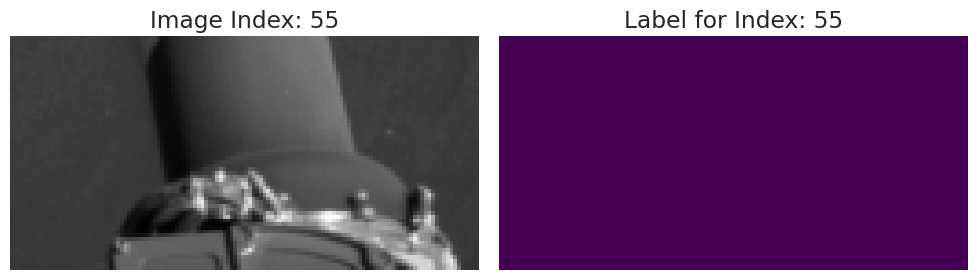

In [29]:
# Example list of indexes you want to display
indexes_to_display = [55]  # Replace with your specific indexes

# Number of images to display
num_images = len(indexes_to_display)

# Create a larger figure to accommodate multiple images and labels
fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

# Loop through the selected indexes
for i, idx in enumerate(indexes_to_display):
    # Image plot
    ax_image = axes[i, 0] if num_images > 1 else axes[0]
    ax_image.imshow(X_train_val[idx], cmap='gray' if X_train_val[idx].ndim == 2 else None)  # Grayscale if 2D
    ax_image.set_title(f"Image Index: {idx}")
    ax_image.axis('off')

    # Label plot
    ax_label = axes[i, 1] if num_images > 1 else axes[1]
    colored_label = apply_colormap(y_train_val[idx], colormap)
    ax_label.imshow(colored_label)
    ax_label.set_title(f"Label for Index: {idx}")
    ax_label.axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

#  

<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">



<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/



<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/

___

Credits: Eugenio Lomurno 📧 eugenio.lomurno@polimi.it











```

   Copyright 2024 Eugenio Lomurno



   Licensed under the Apache License, Version 2.0 (the "License");

   you may not use this file except in compliance with the License.

   You may obtain a copy of the License at



       http://www.apache.org/licenses/LICENSE-2.0



   Unless required by applicable law or agreed to in writing, software

   distributed under the License is distributed on an "AS IS" BASIS,

   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.

   See the License for the specific language governing permissions and

   limitations under the License.

```